In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/revealed_test.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv


In [20]:
cd /kaggle/input/godaddy-microbusiness-density-forecasting

/kaggle/input/godaddy-microbusiness-density-forecasting


# Digital Assignment 2:

**CSE4088: Deep Learning: Principles and Practices** <br />
**Faculty: Dr. Harini S.**


**Team Members:** 
1. Nimish Kashyap - 20BRS1049
2. Nachiket G. Gersappa - 20BRS1070
3. Aditi Jaiswal - 20BRS1184
4. Harsh Ashok Valambe - 20BRS1197

**Dataset Link**: https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting/data

In [53]:
import requests
import json
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta 
import time
import copy
import random
import numpy as np
import os
from collections import defaultdict
import math
global logger
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

**Below code introduces manual seeding:**

In [22]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 1999
seed_everything(seed)

**This block of code contains configuration class that holds important parameters such as batch size, number of workers for multiprocessing, learning rate 0.01 and more. (Refer to document for more explanation)**

In [23]:
class CFG :
    batch_size = 32
    num_workers = 4
    timesize = 2
    hidden = 32
    num_layers = 2
    num_classes = 1
    eps = 0.01
    
# custom function
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

**This block of code is used to load and preprocess the data for the LSTM model.**

In [24]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.cfips = df.cfips.unique() 
        
        
    def __len__(self):
        return len(self.cfips)

    def __getitem__(self, idx):
        ct = self.cfips[idx]
        df_ct = self.df[self.df.cfips == ct]    
        df_ct_arr = df_ct.microbusiness_density

        ft = []
        label = []
        label_all = []
        for i in range(len(df_ct) - CFG.timesize):
            ft.append(df_ct_arr.iloc[i:i+CFG.timesize].to_list())
            label_all.append(df_ct_arr.iloc[i + CFG.timesize])
        label.append(df_ct_arr.iloc[len(df_ct) - 1])

        ft = np.array(ft)
        me = ft.max(axis = 1)
        std = ft.min(axis = 1)
        ft = np.transpose(ft)
        ft = (ft - std)/(me - std + CFG.eps)
        ft = np.transpose(ft)
        label = np.array(label)
        label_scale = (label - std[-1])/(me[-1] - std[-1] + CFG.eps)

        label_all = np.array(label_all)

        ft_scale = sigmoid_v(ft)
        label_scale = sigmoid_v(label_scale)
        
        # return torch.FloatTensor(np.expand_dims(ft, axis = 0)), torch.FloatTensor(np.expand_dims(label, axis = 0))
        return torch.FloatTensor(ft_scale), torch.FloatTensor(label_scale), torch.FloatTensor(label), torch.FloatTensor(std), torch.FloatTensor(me), torch.FloatTensor(label_all)
    

class TestDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.cfips = df.cfips.unique() 
        
        
    def __len__(self):
        return len(self.cfips)

    def __getitem__(self, idx):
        ct = self.cfips[idx]
        df_ct = self.df[self.df.cfips == ct]    
        df_ct_arr = df_ct.microbusiness_density

        ft = []
        label_all = []
        # ft.append(df_ct_arr.iloc[-CFG.timesize:].to_list())
        for i in range(len(df_ct) - CFG.timesize):
            ft.append(df_ct_arr.iloc[i:i+CFG.timesize].to_list())
            label_all.append(df_ct_arr.iloc[i + CFG.timesize])

        ft = np.array(ft)
        me = ft.max(axis = 1)
        std = ft.min(axis = 1)
        ft = np.transpose(ft)
        ft = (ft - std)/(me - std + CFG.eps)
        ft = np.transpose(ft)

        label_all = np.array(label_all)

        ft_scale = sigmoid_v(ft)
        return torch.FloatTensor(ft_scale), torch.FloatTensor(std), torch.FloatTensor(me), torch.Tensor(label_all), ct

In [25]:
train = pd.read_csv('./train.csv')
train["first_day_of_month"] = pd.to_datetime(train["first_day_of_month"])
train = train.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)

In [26]:
test = pd.read_csv('./test.csv')
test["first_day_of_month"] = pd.to_datetime(test["first_day_of_month"])
test = test.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)

In [27]:
print( train.shape )
train.head()

(122265, 7)


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [28]:
df_train = train[train.first_day_of_month < '2022-10-01']
df_val = train[(train.first_day_of_month <= '2022-10-01') & (train.first_day_of_month >= '2019-09-01')]
df_test = train[(train.first_day_of_month <= '2022-10-01') & (train.first_day_of_month >= '2019-10-01')]

**Using dataset loaders:**

In [29]:
train_dataset = TrainDataset(df_train)
val_dataset = TrainDataset(df_val)
test_dataset = TestDataset(df_test)

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)

val_loader = DataLoader(val_dataset,
                          batch_size=CFG.batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)

test_loader = DataLoader(test_dataset,
                          batch_size=CFG.batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [30]:
feature, label, _, __, ___, ____ = next(iter(dataloaders['train']))
print(feature.shape)
print(label.shape)

torch.Size([32, 36, 2])
torch.Size([32, 1])


### Creating the Model:

Model architecture:

1. LSTM Layer: LSTM(2, 32, num_layers=2, batch_first=True)
2. Fully Connected Layer: Linear(in_features=32, out_features=1, bias=True)

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as fun
# class fcmodel(nn.Module):
#     def __init__(self):
#         super(fcmodel, self).__init__()
#         self.fc1   = nn.Linear(6, 120)
#         self.fc2  = nn.Linear(120, 1)

#     def forward(self, y):
#         y = fun.relu(self.fc1(y))
#         y = self.fc2(y)
#         return y
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class fcmodel(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, device):
        super(fcmodel, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        out_fc = self.fc(h_out)
        
        out = out_fc.mean(dim = 0)
        return out

fc = fcmodel(CFG.num_classes, CFG.timesize, CFG.hidden, CFG.num_layers, device).to(device)
print(fc)

fcmodel(
  (lstm): LSTM(2, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [32]:
sample = fc(feature.to(device))
print(sample.shape)

torch.Size([32, 1])


In [33]:
per_epoch_loss = []

In [34]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                num_time_slice = len(df_train) - CFG.timesize
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                num_time_slice = len(df_val) - CFG.timesize
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            count = 0
            num_iter = int(len(df_train.groupby('cfips').count())/CFG.batch_size) 

            for inputs, labels, _, __, ___, ____ in dataloaders[phase]:
                
                count += 1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # _, outputs = torch.max(outputs, 1)
                    loss = loss_func(criterion, outputs, labels.squeeze(-1), metrics)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)
                if (count + 1) % 20 == 0:
                    print('Epoch {}/{} - Iter {}/{}'.format(epoch+1, num_epochs, count + 1, num_iter))
                    print_metrics(metrics, epoch_samples, phase)
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples 
            acc = metrics['acc'] / epoch_samples 
            per_epoch_loss.append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), '/kaggle/working/baseline.pth')

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [35]:
def loss_func(criterion, pred, target, metrics):
    loss = criterion(pred, target)
    mae = nn.L1Loss()
    metr = mae(pred, target)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    metrics['acc'] += metr.data.cpu().numpy() * target.size(0)
    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))


In [36]:
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, fc.parameters()), lr=5*1e-3)
#criterion = nn.MSELoss()
criterion = nn.L1Loss(reduction='mean')
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 5, gamma=0.6)

model = train_model(fc, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
LR 0.005


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 1/15 - Iter 20/97
train: loss: 0.270540, acc: 0.270540
Epoch 1/15 - Iter 40/97
train: loss: 0.214162, acc: 0.214162
Epoch 1/15 - Iter 60/97
train: loss: 0.196513, acc: 0.196513
Epoch 1/15 - Iter 80/97
train: loss: 0.189024, acc: 0.189024
train: loss: 0.185172, acc: 0.185172
Epoch 1/15 - Iter 20/97
val: loss: 0.177708, acc: 0.177708
Epoch 1/15 - Iter 40/97
val: loss: 0.179682, acc: 0.179682
Epoch 1/15 - Iter 60/97
val: loss: 0.181804, acc: 0.181804
Epoch 1/15 - Iter 80/97
val: loss: 0.182981, acc: 0.182981
val: loss: 0.181757, acc: 0.181757
saving best model
0m 14s
Epoch 1/14
----------
LR 0.005
Epoch 2/15 - Iter 20/97
train: loss: 0.162674, acc: 0.162674
Epoch 2/15 - Iter 40/97
train: loss: 0.164100, acc: 0.164100
Epoch 2/15 - Iter 60/97
train: loss: 0.167557, acc: 0.167557
Epoch 2/15 - Iter 80/97
train: loss: 0.164921, acc: 0.164921
train: loss: 0.165751, acc: 0.165751
Epoch 2/15 - Iter 20/97
val: loss: 0.195611, acc: 0.195611
Epoch 2/15 - Iter 40/97
val: loss: 0.198772, acc: 0.

In [37]:
print(per_epoch_loss)

[0.18517155853128925, 0.18175703041332283, 0.16575144431025712, 0.19914876646602275, 0.1674330386611604, 0.2005235827767972, 0.1666135371653075, 0.19147787511963205, 0.16554212708448626, 0.18216727259232826, 0.16545078703730376, 0.19603084811230295, 0.1656346619129181, 0.18533274915414988, 0.16733145652358064, 0.19016875388081542, 0.16610737191033118, 0.19100668703772358, 0.16540287396649725, 0.1975491026934889, 0.16559316578906835, 0.18272261413716778, 0.16579206226412782, 0.18771695322597148, 0.1653999596373322, 0.18380182797146827, 0.16567470632570305, 0.18919257788928515, 0.16584598841433673, 0.18843952128567645]


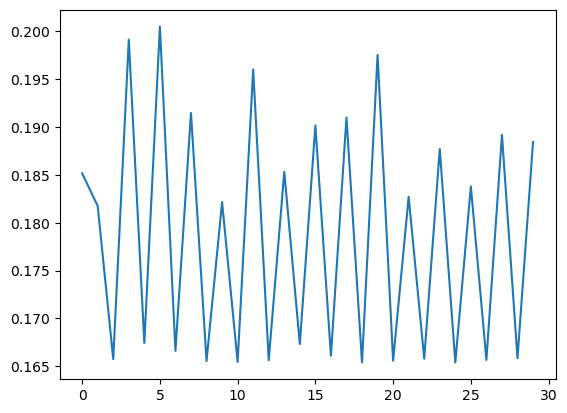

In [54]:
plt.plot(per_epoch_loss)

In [38]:
feature, label,_, __, ___,____ = next(iter(dataloaders['val']))
print(feature.shape)
print(label.shape)

sample = feature[0]
sample.shape


torch.Size([32, 36, 2])
torch.Size([32, 1])


torch.Size([36, 2])

In [39]:
label

tensor([[4.6054e-01],
        [7.4871e-01],
        [5.0000e-01],
        [6.8002e-01],
        [7.8121e-01],
        [6.5090e-01],
        [7.8200e-01],
        [5.0000e-01],
        [5.0000e-01],
        [9.3623e-01],
        [9.0053e-01],
        [7.8406e-01],
        [8.4300e-04],
        [7.7376e-01],
        [4.6337e-01],
        [3.2431e-01],
        [5.0000e-01],
        [6.0686e-01],
        [5.9629e-01],
        [5.2681e-01],
        [7.2812e-01],
        [2.3806e-01],
        [7.4699e-01],
        [4.6217e-01],
        [8.7158e-01],
        [6.7631e-01],
        [6.8959e-01],
        [5.0000e-01],
        [7.5043e-01],
        [3.0333e-01],
        [5.5068e-01],
        [7.9977e-01]])

In [40]:
pred = model(feature.to(device)).squeeze()
pred = -torch.log(1/pred - 1)
print(pred)

tensor([0.4632, 0.4770, 0.4382, 0.4509, 0.4767, 0.4663, 0.4795, 0.4675, 0.4481,
        0.4676, 0.4585, 0.4568, 0.4556, 0.4805, 0.4757, 0.4550, 0.4543, 0.4602,
        0.4636, 0.4630, 0.4632, 0.4376, 0.4513, 0.4581, 0.4680, 0.4495, 0.4568,
        0.4569, 0.4792, 0.4590, 0.4736, 0.4755], device='cuda:0',
       grad_fn=<NegBackward0>)


In [41]:
print(-torch.log(1/pred - 1))

tensor([-0.1475, -0.0921, -0.2484, -0.1969, -0.0934, -0.1352, -0.0821, -0.1304,
        -0.2082, -0.1299, -0.1664, -0.1734, -0.1782, -0.0780, -0.0973, -0.1806,
        -0.1834, -0.1594, -0.1457, -0.1483, -0.1475, -0.2508, -0.1955, -0.1680,
        -0.1282, -0.2029, -0.1732, -0.1728, -0.0832, -0.1643, -0.1059, -0.0982],
       device='cuda:0', grad_fn=<NegBackward0>)


In [42]:
std = __[:, -1].to(device)
me = ___[:, - 1].to(device)

_

tensor([[4.4557],
        [8.5212],
        [1.8503],
        [0.7237],
        [2.4360],
        [2.0160],
        [5.9374],
        [2.5238],
        [1.4100],
        [3.5594],
        [2.6703],
        [2.0941],
        [4.8146],
        [7.8639],
        [2.2183],
        [2.1570],
        [0.4922],
        [1.3007],
        [3.0035],
        [5.3570],
        [2.0931],
        [0.7329],
        [1.0628],
        [2.0112],
        [1.1826],
        [0.2520],
        [1.8987],
        [1.0428],
        [4.8948],
        [3.5758],
        [2.9777],
        [6.6074]])

In [43]:
torch.mul(pred , (me - std + CFG.eps)) + std

tensor([4.4854, 8.4769, 1.8583, 0.7207, 2.3834, 2.0119, 5.5577, 2.5385, 1.4145,
        3.5114, 2.6392, 2.0810, 4.9588, 7.8295, 2.2417, 2.1758, 0.4996, 1.3015,
        3.0056, 5.3713, 2.0720, 0.7489, 1.0448, 2.0363, 1.1426, 0.2411, 1.8818,
        1.0521, 4.8350, 3.6023, 3.0309, 6.5658], device='cuda:0',
       grad_fn=<AddBackward0>)

In [44]:
feature, _, __, label_all, ct = next(iter(dataloaders['test']))
print(feature.shape)
ct

torch.Size([32, 35, 2])


tensor([1001, 1003, 1005, 1007, 1009, 1011, 1013, 1015, 1017, 1019, 1021, 1023,
        1025, 1027, 1029, 1031, 1033, 1035, 1037, 1039, 1041, 1043, 1045, 1047,
        1049, 1051, 1053, 1055, 1057, 1059, 1061, 1063])

In [45]:
pred_test = model(feature.to(device)).squeeze()
pred_test = -torch.log(1/pred_test - 1)
pred_test

tensor([0.4707, 0.4718, 0.4603, 0.4719, 0.4651, 0.4633, 0.4843, 0.4678, 0.4613,
        0.4449, 0.4581, 0.4661, 0.4635, 0.4456, 0.4594, 0.4765, 0.4658, 0.4612,
        0.4502, 0.4484, 0.4495, 0.4581, 0.4530, 0.4532, 0.4462, 0.4606, 0.4721,
        0.4560, 0.4622, 0.4636, 0.4663, 0.4766], device='cuda:0',
       grad_fn=<NegBackward0>)

In [46]:
std = _[:, -1].to(device)
me = __[:, - 1].to(device)

In [47]:
torch.mul(pred_test , (me - std + CFG.eps)) + std

tensor([3.4374, 8.4169, 1.2060, 1.3082, 1.8483, 0.9733, 2.1410, 2.8028, 1.5163,
        1.1361, 1.7715, 1.6454, 1.3544, 1.6253, 1.3594, 2.1786, 2.3815, 1.1515,
        0.8217, 1.6749, 1.0844, 2.6837, 1.7785, 1.4747, 2.2534, 3.3177, 1.9051,
        2.7303, 1.0590, 1.9582, 1.4346, 1.4057], device='cuda:0',
       grad_fn=<AddBackward0>)

In [48]:
label_all

tensor([[2.9932, 2.9691, 2.9093,  ..., 3.4239, 3.4427, 3.4639],
        [7.4703, 7.4137, 7.2825,  ..., 8.4911, 8.3417, 8.3598],
        [1.0006, 1.0272, 1.0223,  ..., 1.1967, 1.2068, 1.2321],
        ...,
        [1.4156, 1.3945, 1.4029,  ..., 1.9830, 1.9281, 1.9323],
        [1.2867, 1.2697, 1.2745,  ..., 1.4232, 1.4377, 1.4523],
        [1.2244, 1.2797, 1.3102,  ..., 1.3788, 1.4253, 1.4407]])

In [49]:
df = pd.DataFrame(columns = ['row_id','microbusiness_density'])
df = df.append({'row_id':'1001_2022-11-01','microbusiness_density':3.2}, ignore_index=True)
df

,row_id,microbusiness_density
0,1001_2022-11-01,3.2


In [50]:
df = pd.DataFrame(columns = ['row_id','microbusiness_density'])
datestart = pd.to_datetime('2022-11-01')
count = 0
for feature, _, __, label_all, ct in dataloaders['test']:
    print(f'Checking {count}')
    count += 1
    for i in range(ct.shape[0]):
        ft = feature[i : i + 1].to(device)
        std = _[i:i+1, -1].to(device)
        me = __[i:i+1, - 1].to(device)
        for j in range(8):
            datecheck = (datestart + relativedelta(months = j)).strftime('%Y-%m-%d')
            pred_test = model(ft.to(device)).squeeze()
            pred_test = -torch.log(1/pred_test - 1)
            final_pred = torch.mul(pred_test , (me - std + CFG.eps)) + std
            final_pred_item = final_pred.item()
            df = df.append({'row_id': str(ct[i].item()) + '_' + str(datecheck),'microbusiness_density':final_pred_item}, ignore_index=True)

            last_ft = ft[0][-1]
            last_ft_cat = torch.cat([last_ft, final_pred], dim = 0)
            last_ft_cat = last_ft_cat[1:]
            ft = torch.cat([ft[0][1:], last_ft_cat.unsqueeze(0)], dim = 0)
            ft = ft.unsqueeze(0)
            
df.head(20)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Checking 0
Checking 1
Checking 2
Checking 3
Checking 4
Checking 5
Checking 6
Checking 7
Checking 8
Checking 9
Checking 10
Checking 11
Checking 12
Checking 13
Checking 14
Checking 15
Checking 16
Checking 17
Checking 18
Checking 19
Checking 20
Checking 21
Checking 22
Checking 23
Checking 24
Checking 25
Checking 26
Checking 27
Checking 28
Checking 29
Checking 30
Checking 31
Checking 32
Checking 33
Checking 34
Checking 35
Checking 36
Checking 37
Checking 38
Checking 39
Checking 40
Checking 41
Checking 42
Checking 43
Checking 44
Checking 45
Checking 46
Checking 47
Checking 48
Checking 49
Checking 50
Checking 51
Checking 52
Checking 53
Checking 54
Checking 55
Checking 56
Checking 57
Checking 58
Checking 59
Checking 60
Checking 61
Checking 62
Checking 63
Checking 64
Checking 65
Checking 66
Checking 67
Checking 68
Checking 69
Checking 70
Checking 71
Checking 72
Checking 73
Checking 74
Checking 75
Checking 76
Checking 77
Checking 78
Checking 79
Checking 80
Checking 81
Checking 82
Checking 83
Ch

,row_id,microbusiness_density
0,1001_2022-11-01,3.437419
1,1001_2022-12-01,3.447712
2,1001_2023-01-01,3.456539
3,1001_2023-02-01,3.462421
4,1001_2023-03-01,3.465898
5,1001_2023-04-01,3.467987
6,1001_2023-05-01,3.469260
7,1001_2023-06-01,3.470049
8,1003_2022-11-01,8.416922
9,1003_2022-12-01,8.543283


In [51]:
df.to_csv('/kaggle/working/submission.csv',index=False)